<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22MNIST_PNG(LeNet)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/JavohirJalilov/Datasets/raw/main/Classification/mnist_png.tar.gz

--2023-07-06 14:35:24--  https://github.com/JavohirJalilov/Datasets/raw/main/Classification/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JavohirJalilov/Datasets/main/Classification/mnist_png.tar.gz [following]
--2023-07-06 14:35:25--  https://raw.githubusercontent.com/JavohirJalilov/Datasets/main/Classification/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz’

mnist_png.tar.gz    100%[===================>]  14.96M  --.-KB/s    in 0.07s   

2023-07-06 14:35:26 (207 MB/s) - ‘mnist_png.tar.gz

In [ ]:
!tar -xzf /content/mnist_png.tar.gz

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from torchinfo import summary
import pathlib
from PIL import Image
import torchvision.transforms as T

In [ ]:
from tqdm import tqdm

In [ ]:
train_path = pathlib.Path("/content/mnist_png/training")
test_path = pathlib.Path("/content/mnist_png/testing")

In [ ]:
x = train_path.glob("*/*.png")

In [ ]:
for i in x:
  print(i.parts[-2])
  break

4


In [ ]:
transform = T.Compose([
    T.Resize(size=32),
    T.ToTensor()
])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
device

'cuda'

In [ ]:
class MNISTDataset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.png'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]

        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [ ]:
train_dataset = MNISTDataset(train_path, transform)
test_dataset = MNISTDataset(test_path, transform)

In [ ]:
img, label = next(iter(test_dataset))

In [ ]:
img.shape

torch.Size([1, 32, 32])

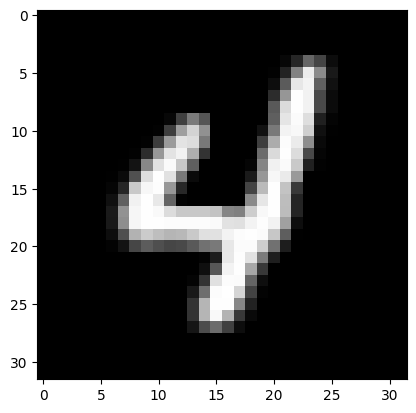

In [ ]:
plt.imshow(img[0],cmap='gray')

In [ ]:
x = img.permute(1,2,0)
x.shape

torch.Size([32, 32, 1])

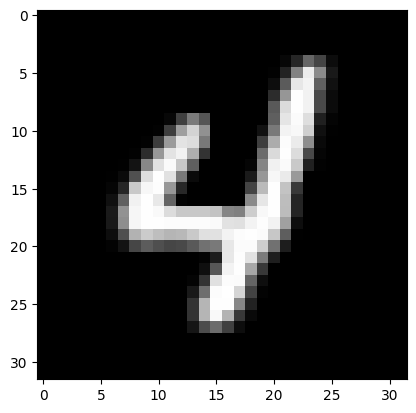

In [ ]:
plt.imshow(img.permute(1,2,0), cmap='gray')
plt.show()

In [ ]:
train_data = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=64, shuffle=True)

# MODEL LeNet


![image](https://www.philschmid.de/static/blog/getting-started-with-cnn-by-calculating-lenet-layer-manually/lenet-5.svg)

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    # 32X32X1
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6,
                           kernel_size = 5, stride = 1, padding = 0)
    # 28X28X6
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16,
                           kernel_size = 5, stride = 1, padding = 0)
    # 14X14X6
    self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 120,
                           kernel_size = 5, stride = 1, padding = 0)
    # 10X10X16

    # AVG POLL 5X5X16

    self.linear1 = nn.Linear(120, 84)
    self.linear2 = nn.Linear(84, 10)
    self.tanh = nn.Tanh()
    self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

  def forward(self, x):
    # 32X32X1
    x = self.conv1(x)
    x = self.tanh(x)
    # 28X28X6
    x = self.avgpool(x)
    # 14x14x6
    x = self.conv2(x)
    # 10x10x16
    x = self.tanh(x)
    x = self.avgpool(x)
    # 5x5x16
    x = self.conv3(x)
    # 1x1x120

    x = self.tanh(x)

    x = x.reshape(x.shape[0], -1)
    # 120
    x = self.linear1(x)
    # 84
    x = self.tanh(x)
    # 84
    x = self.linear2(x)
    # 10
    return x

In [ ]:
model = LeNet()

In [ ]:
# loss and optimizer
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
num_epochs = 5

In [ ]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [ ]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [ ]:
trainer.train()

100%|██████████| 157/157 [00:04<00:00, 32.65it/s]



Epoch[1/5] 	 train_loss: 0.29533, train_acc: 0.91 	 val_loss: 0.11257 	 val_acc: 0.96


100%|██████████| 157/157 [00:03<00:00, 39.70it/s]



Epoch[2/5] 	 train_loss: 0.09335, train_acc: 0.97 	 val_loss: 0.07216 	 val_acc: 0.98


100%|██████████| 157/157 [00:04<00:00, 33.26it/s]



Epoch[3/5] 	 train_loss: 0.06160, train_acc: 0.98 	 val_loss: 0.06071 	 val_acc: 0.98


100%|██████████| 157/157 [00:03<00:00, 40.21it/s]



Epoch[4/5] 	 train_loss: 0.04794, train_acc: 0.99 	 val_loss: 0.05602 	 val_acc: 0.98


100%|██████████| 157/157 [00:04<00:00, 34.51it/s]


Epoch[5/5] 	 train_loss: 0.03631, train_acc: 0.99 	 val_loss: 0.04929 	 val_acc: 0.98


In [ ]:
test_img, test_label = next(iter(test_data))

In [ ]:
pred = model(test_img.to(device))

In [ ]:
pred = pred.argmax(axis=1)

In [ ]:
pred.device

device(type='cpu')

In [ ]:
pred = pred.detach().cpu()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
test_label

tensor([8, 3, 1, 9, 0, 1, 5, 3, 3, 0, 6, 9, 3, 1, 2, 5, 0, 3, 5, 0, 5, 5, 2, 1,
        3, 8, 8, 4, 3, 2, 6, 0, 3, 2, 9, 5, 7, 6, 0, 5, 6, 1, 9, 1, 3, 5, 2, 4,
        4, 9, 9, 5, 0, 5, 9, 1, 0, 8, 1, 2, 8, 8, 4, 2])

In [ ]:
cm = confusion_matrix(test_label, pred)

In [ ]:
cm

array([[ 8,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 10,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  6,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7]])

<Axes: >

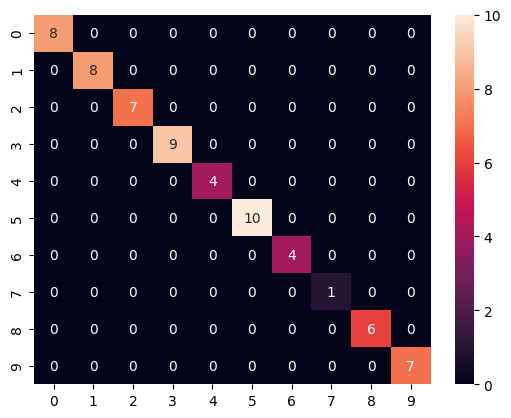

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)